In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
import sys
import warnings
import scipy.stats as stats

if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Load Dataset

In [4]:
dirname = '/Users/Friso/PycharmProjects/Master_Thesis/Project/'

dirname = '/Users/Friso/PycharmProjects/Master_Thesis/Project/'

df_ARWU2018 = pd.read_csv(dirname + 'ARWU/data/grid4/ARWURanking_2018_grid.csv')
df_ARWU2018['GRID_ID'] = df_ARWU2018['GRID_ID'].replace('-1', np.NaN)
display(df_ARWU2018.describe())

df_QS2018 = pd.read_csv(dirname + 'QS/data/grid4/qs2019_grid.csv')
df_QS2018['GRID_ID'] = df_QS2018['GRID_ID'].replace('-1', np.NaN)
display(df_QS2018.describe())

df_THE2018 = pd.read_csv(dirname + 'THE/data/grid4/THERanking2019__grid.csv')
df_THE2018['GRID_ID'] = df_THE2018['GRID_ID'].replace('-1', np.NaN)
display(df_THE2018.describe())

,Unnamed: 0,TotalScore,Alumni,Award,HiCi,NS,PUB,PCP,fuzz
count,500.000000,100.000000,500.00000,500.000000,500.000000,497.000000,500.000000,500.000000,4.000000
mean,249.500000,36.695000,8.25980,7.651400,16.716200,15.335412,41.771000,23.589200,100.000000
std,144.481833,12.872972,12.94563,15.542057,12.951746,11.951393,13.287646,9.511244,3.464102
min,0.000000,25.100000,0.00000,0.000000,0.000000,0.000000,8.900000,11.300000,95.000000
25%,124.750000,27.700000,0.00000,0.000000,9.600000,8.000000,32.475000,17.800000,99.500000
50%,249.500000,32.550000,0.00000,0.000000,13.500000,12.200000,39.400000,21.600000,101.000000
75%,374.250000,39.750000,13.40000,13.100000,21.400000,18.900000,48.850000,26.625000,101.500000
max,499.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,103.000000


,Unnamed: 0,score_list,Academic_reputation,Employer_reputation,Faculty_Student,International_Faculty,International_Students,Citations,fuzz
count,1021.000000,504.000000,600.000000,631.000000,718.000000,689.000000,709.000000,695.000000,15.000000
mean,510.000000,44.121032,36.770000,38.371791,49.721866,52.305370,46.071227,41.267914,100.333333
std,294.881615,18.634072,25.501519,26.225093,27.784011,33.282497,30.932449,24.862123,5.875697
min,0.000000,23.500000,3.000000,2.500000,4.000000,1.500000,1.000000,1.000000,86.000000
25%,255.000000,29.200000,18.200000,19.350000,27.000000,20.900000,19.500000,21.550000,101.000000
50%,510.000000,37.950000,27.800000,30.800000,43.250000,45.800000,38.900000,36.900000,103.000000
75%,765.000000,54.100000,49.300000,52.100000,73.750000,88.100000,72.200000,58.400000,103.000000
max,1020.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,103.000000


,Teaching,Rechearch,Citations,Industry_Income,Internationals_Outlook,student_staff_ratio,fuzz
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,197.000000
mean,28.667965,24.272496,48.556280,46.445628,47.272099,19.153100,101.456853
std,14.894419,17.708966,28.548184,16.396566,23.357015,26.067826,0.752151
min,9.200000,6.600000,1.400000,34.000000,12.700000,0.900000,101.000000
25%,18.200000,11.500000,23.300000,35.600000,27.200000,12.225000,101.000000
50%,24.300000,18.750000,44.700000,39.450000,43.550000,16.500000,101.000000
75%,34.475000,30.700000,73.775000,49.800000,62.900000,21.800000,102.000000
max,94.500000,99.500000,100.000000,100.000000,99.800000,865.800000,103.000000


### Create dataframes

In [5]:
# merge ARWU with QS
df = pd.merge(df_ARWU2018, df_QS2018, on='GRID_ID', how='left')

# merge df with THE
df = pd.merge(df, df_THE2018, on='GRID_ID', how='left')
df = df[['Name_x', 'Alumni', 'Award', 'HiCi', 'NS', 'PUB', 'PCP', 'Academic_reputation', 'Employer_reputation',
         'Faculty_Student', 'International_Faculty', 'International_Students', 'Citations_x', 'Teaching',
         'Rechearch', 'Citations_y', 'Industry_Income', 'Internationals_Outlook', 'GRID_ID', 'rank', 'Rank', 'WorldRank']]
df = df.dropna()  # drop rows with missing values
print('Remaining number of Universities: {}'.format(df.shape[0]))

display(df.describe())

# create dataframe with overall rankings
df_ranking = df[['Name_x', 'rank', 'Rank', 'WorldRank']]
df_ranking = df_ranking.rename(columns={"Name_x": 'University', "rank": "THES_Rank", "Rank": "QS_Rank", 'WorldRank': 'ARWU_Rank'})
df_ranking = df_ranking.set_index('University')
df_ranking['THES_Rank'] = df_ranking['THES_Rank'].str.replace('=', '')
df_ranking['QS_Rank'] = df_ranking['QS_Rank'].str.replace('=', '')
for index, row in df_ranking.iterrows():
    THES_Rank = row['THES_Rank'].split('–')
    THES_Rank = [int(x) for x in THES_Rank]
    THES_Rank = np.mean(THES_Rank)
    df_ranking.loc[index, 'THES_Rank'] = THES_Rank
    
    ARWU_Rank = row['ARWU_Rank'].split('-')
    ARWU_Rank = [int(x) for x in ARWU_Rank]
    ARWU_Rank = np.mean(ARWU_Rank)
    df_ranking.loc[index, 'ARWU_Rank'] = ARWU_Rank
            
# create dataframe which only contains data_ranking data
df_data = df[['Name_x', 'Alumni', 'Award', 'HiCi', 'NS', 'PUB', 'PCP', 'Academic_reputation', 'Employer_reputation',
              'Faculty_Student', 'International_Faculty', 'International_Students', 'Citations_x', 'Teaching',
              'Rechearch', 'Citations_y', 'Industry_Income', 'Internationals_Outlook']].copy(deep=True)
df_data = df_data.rename(columns={"Citations_x": 'QS_Citations', "Citations_y": "THES_Citations"})
df_data = df_data.set_index('Name_x')
# display(df_data.head())

Remaining number of Universities: 348


,Alumni,Award,HiCi,NS,PUB,PCP,Academic_reputation,Employer_reputation,Faculty_Student,International_Faculty,International_Students,Citations_x,Teaching,Rechearch,Citations_y,Industry_Income,Internationals_Outlook
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,10.268966,9.464655,18.824425,17.816379,45.328448,25.133908,47.714368,44.830747,50.607759,58.664368,49.080172,51.711207,44.381609,44.472989,74.801437,55.692529,64.963506
std,14.266751,17.303760,13.980394,12.588687,13.130227,9.454484,26.685108,28.975035,29.859554,33.871140,31.755031,23.753825,16.998768,19.315672,20.070113,19.913358,21.171018
min,0.000000,0.000000,0.000000,0.000000,18.700000,11.600000,4.100000,4.900000,4.000000,1.600000,2.000000,4.000000,17.600000,12.000000,14.700000,34.000000,18.800000
25%,0.000000,0.000000,9.600000,10.175000,35.600000,19.600000,25.100000,21.600000,24.625000,26.375000,20.650000,33.375000,32.200000,30.250000,65.575000,40.025000,50.275000
50%,5.100000,0.000000,16.600000,14.650000,43.000000,23.200000,40.100000,37.150000,46.050000,62.050000,42.900000,50.550000,41.050000,40.000000,79.100000,47.900000,63.750000
75%,16.100000,16.100000,25.300000,21.450000,53.425000,28.125000,65.625000,68.100000,77.625000,93.500000,81.375000,67.950000,51.950000,53.800000,90.200000,67.375000,83.725000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,94.500000,99.500000,99.900000,100.000000,99.800000


### Correlations

In [7]:
cor = df_data.corr()
cor_unstacked = cor.unstack()
cor_unstacked = cor_unstacked[cor_unstacked != 1].drop_duplicates()
# display(cor_unstacked.sort_values(ascending=False).head(20))
# plt.figure(figsize = (10,10))
# sns.heatmap(cor, square=True)

cor3 = df_ranking.astype(float).corr('spearman')
cor3_5 = df_ranking.head(50).astype(float).corr('spearman')
cor3_6 = df_ranking.iloc[50:100].astype(float).corr('spearman')
display(cor3, cor3_5, cor3_6)

cor2 = df_data[['PUB', 'QS_Citations', 'THES_Citations', 'NS']].copy()
cor2['ARWU_Citations'] = (cor2['PUB'] + cor2['NS']) / 2
cor2 = cor2.drop(['NS', 'PUB'], axis=1)
cor2 = cor2.corr('spearman')
display(cor2)
tau1, p_value1 = stats.kendalltau(df_data['QS_Citations'], df_data['THES_Citations'])


cor4 = df_data[['Faculty_Student', 'Teaching', 'Alumni']].copy()
cor4 = cor4.rename(columns={"Faculty_Student": 'QS_Education', "Teaching": "THES_Education", "Alumni": "ARWU_Education"})
display(cor4.corr('spearman'))

,THES_Rank,QS_Rank,ARWU_Rank
THES_Rank,1.000000,0.801226,0.775164
QS_Rank,0.801226,1.000000,0.667391
ARWU_Rank,0.775164,0.667391,1.000000


,THES_Rank,QS_Rank,ARWU_Rank
THES_Rank,1.000000,0.922829,0.814499
QS_Rank,0.922829,1.000000,0.764011
ARWU_Rank,0.814499,0.764011,1.000000


,THES_Rank,QS_Rank,ARWU_Rank
THES_Rank,1.000000,0.718965,0.222306
QS_Rank,0.718965,1.000000,0.268696
ARWU_Rank,0.222306,0.268696,1.000000


,QS_Citations,THES_Citations,ARWU_Citations
QS_Citations,1.000000,0.402087,0.360187
THES_Citations,0.402087,1.000000,0.451401
ARWU_Citations,0.360187,0.451401,1.000000


,QS_Education,THES_Education,ARWU_Education
QS_Education,1.000000,0.477624,0.294235
THES_Education,0.477624,1.000000,0.463631
ARWU_Education,0.294235,0.463631,1.000000


### PCA and Clustering

In [8]:
def doKmeans(df, nclust):
    model = KMeans(nclust)
    model.fit(df)
    print(model.n_iter_)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    df['kmeans']  = clust_labels
    return df

In [9]:
def doPCA(df):
    columns = df.columns
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df.values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    df_loadings = pd.DataFrame(pca.components_)
    df_loadings.columns = columns
    df_loadings = df_loadings.T.rename(columns = {0: 'PCA1', 1:'PCA2'})
    return(df, df_loadings)

####  Individual Rankings

In [10]:
# Format individual ranking clusters
ARWU_data = ['Alumni', 'Award', 'HiCi', 'NS', 'PUB', 'PCP']
df_ARWU2018_data = df_ARWU2018.copy()
df_ARWU2018_data = df_ARWU2018_data[['Name'] + ARWU_data]
df_ARWU2018_data = df_ARWU2018_data.set_index('Name')
df_ARWU2018_data = df_ARWU2018_data.dropna()
display(df_ARWU2018_data.corr())

QS_data = ['Academic_reputation', 'Employer_reputation', 'Faculty_Student', 'International_Faculty', 'International_Students', 'Citations']
df_QS2018_data = df_QS2018.copy()
df_QS2018_data = df_QS2018_data[['Name'] + QS_data]
df_QS2018_data = df_QS2018_data.set_index('Name')
df_QS2018_data = df_QS2018_data.dropna()
display(df_QS2018_data.corr())

THE_data = ['Teaching', 'Rechearch', 'Citations', 'Industry_Income', 'Internationals_Outlook']
df_THE2018_data = df_THE2018.copy()
df_THE2018_data = df_THE2018_data[['Name'] + THE_data]
df_THE2018_data = df_THE2018_data.set_index('Name')
df_THE2018_data = df_THE2018_data.dropna()
display(df_THE2018_data.corr())

,Alumni,Award,HiCi,NS,PUB,PCP
Alumni,1.000000,0.775603,0.470134,0.710693,0.407207,0.632884
Award,0.775603,1.000000,0.530871,0.750540,0.384067,0.689041
HiCi,0.470134,0.530871,1.000000,0.731655,0.580480,0.581896
NS,0.710693,0.750540,0.731655,1.000000,0.608510,0.693701
PUB,0.407207,0.384067,0.580480,0.608510,1.000000,0.366229
PCP,0.632884,0.689041,0.581896,0.693701,0.366229,1.000000


,Academic_reputation,Employer_reputation,Faculty_Student,International_Faculty,International_Students,Citations
Academic_reputation,1.000000,0.794506,0.146609,0.201385,0.201622,0.436716
Employer_reputation,0.794506,1.000000,0.142603,0.260584,0.291557,0.300382
Faculty_Student,0.146609,0.142603,1.000000,-0.062308,0.021371,-0.190081
International_Faculty,0.201385,0.260584,-0.062308,1.000000,0.663985,0.311961
International_Students,0.201622,0.291557,0.021371,0.663985,1.000000,0.230996
Citations,0.436716,0.300382,-0.190081,0.311961,0.230996,1.000000


,Teaching,Rechearch,Citations,Industry_Income,Internationals_Outlook
Teaching,1.000000,0.897481,0.563759,0.412874,0.368407
Rechearch,0.897481,1.000000,0.638822,0.491657,0.509105
Citations,0.563759,0.638822,1.000000,0.205725,0.605854
Industry_Income,0.412874,0.491657,0.205725,1.000000,0.153132
Internationals_Outlook,0.368407,0.509105,0.605854,0.153132,1.000000


In [11]:
df_ARWU2018_pca, ARWU_loadings = doPCA(df_ARWU2018_data[ARWU_data])
df_QS2018_pca, QS_loadings = doPCA(df_QS2018_data[QS_data])
df_THE2018_pca, THE_loadings = doPCA(df_THE2018_data[THE_data])
display(ARWU_loadings, QS_loadings, THE_loadings)

Explained variation per principal component: [0.6703267  0.15044577]
Explained variation per principal component: [0.42559091 0.22248419]
Explained variation per principal component: [0.64396474 0.16235777]


,PCA1,PCA2
Alumni,0.422413,0.341212
Award,0.535336,0.467626
HiCi,0.392491,-0.410143
NS,0.427375,-0.079902
PUB,0.338762,-0.690017
PCP,0.289006,0.119055


,PCA1,PCA2
Academic_reputation,0.332100,0.533802
Employer_reputation,0.374440,0.514548
Faculty_Student,0.007332,0.448892
International_Faculty,0.605905,-0.397003
International_Students,0.541474,-0.290495
Citations,0.298556,0.082423


,PCA1,PCA2
Teaching,0.290586,0.396134
Rechearch,0.391123,0.416832
Citations,0.705831,-0.198532
Industry_Income,0.161509,0.624794
Internationals_Outlook,0.488160,-0.489435


12
10
16


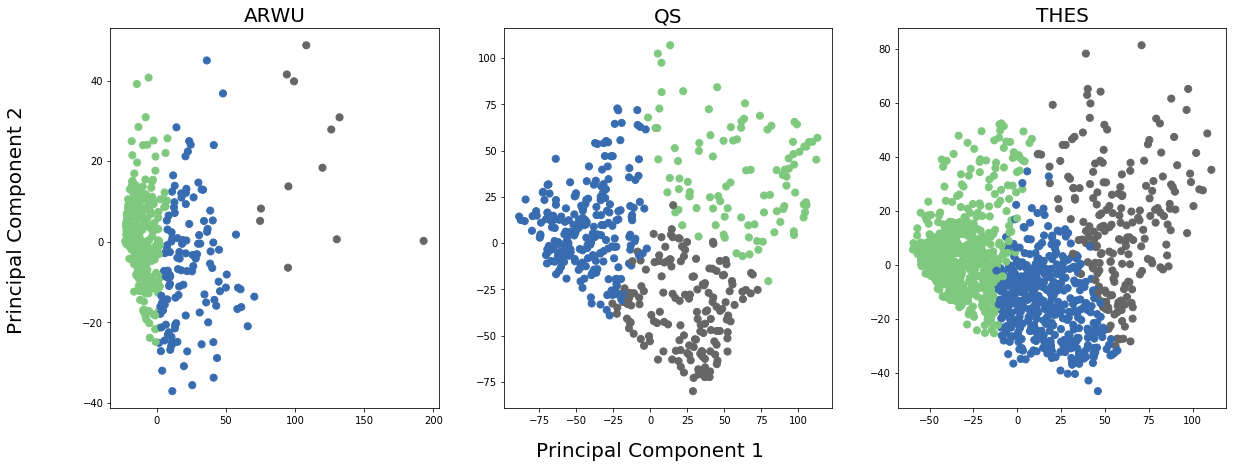

In [12]:
df_ARWU2018_kmeans = doKmeans(df_ARWU2018_data[ARWU_data], 3)
df_QS2018_kmeans = doKmeans(df_QS2018_data[QS_data], 3)
df_THE2018_kmeans = doKmeans(df_THE2018_data[THE_data], 3)

fig, ([ax1, ax2, ax3]) = plt.subplots(1, 3, figsize=(20,7))
ax1.scatter(df_ARWU2018_pca['pca-one'], df_ARWU2018_pca['pca-two'],
                     c=df_ARWU2018_kmeans['kmeans'], s=50, cmap='Accent')
ax1.set_title('ARWU', fontsize=20)

ax2.scatter(df_QS2018_pca['pca-one'], df_QS2018_pca['pca-two'],
                     c=df_QS2018_kmeans['kmeans'], s=50, cmap='Accent')
ax2.set_title('QS', fontsize=20)

ax3.scatter(df_THE2018_pca['pca-one'], df_THE2018_pca['pca-two'],
                     c=df_THE2018_kmeans['kmeans'], s=50, cmap='Accent')
ax3.set_title('THES', fontsize=20)

fig.text(0.5, 0.04, 'Principal Component 1', ha='center', va='center', fontsize=20)
fig.text(0.06, 0.5, 'Principal Component 2', ha='center', va='center', rotation='vertical', fontsize=20)

fig.savefig('PCA+Clusters', bbox_inches='tight')

#### Combined Rankings

In [13]:
df_pca = df_data.copy()

df_pca_pca, df_pca_loadings = doPCA(df_pca)
display(df_pca_loadings)

Explained variation per principal component: [0.41209497 0.21580807]


,PCA1,PCA2
Alumni,0.137546,0.121797
Award,0.173241,0.135300
HiCi,0.158891,0.084056
NS,0.146701,0.114366
PUB,0.114933,0.169639
PCP,0.111431,0.039915
Academic_reputation,0.347159,0.310258
Employer_reputation,0.374275,0.226742
Faculty_Student,0.198036,0.308759
International_Faculty,0.388546,-0.522864


9


Text(0.06, 0.5, 'Principal Component 2')

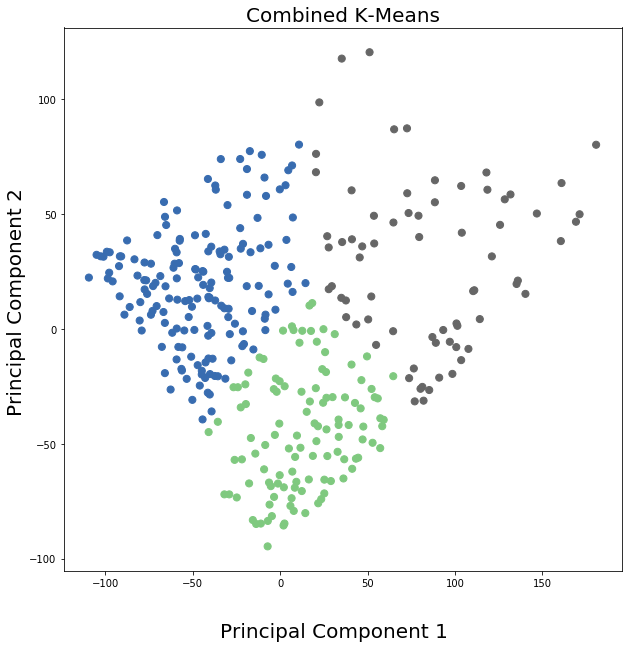

In [14]:
df_kmeans = df_data.copy()
df_kmeans_kmeans = doKmeans(df_kmeans, 3)

fig, (ax1) = plt.subplots(1, 1, figsize=(10,10))
ax1.scatter(df_pca_pca['pca-one'], df_pca_pca['pca-two'],
                     c=df_kmeans_kmeans['kmeans'], s=50, cmap='Accent')
ax1.set_title('Combined K-Means', fontsize=20)
fig.text(0.5, 0.04, 'Principal Component 1', ha='center', va='center', fontsize=20)
fig.text(0.06, 0.5, 'Principal Component 2', ha='center', va='center', rotation='vertical', fontsize=20)

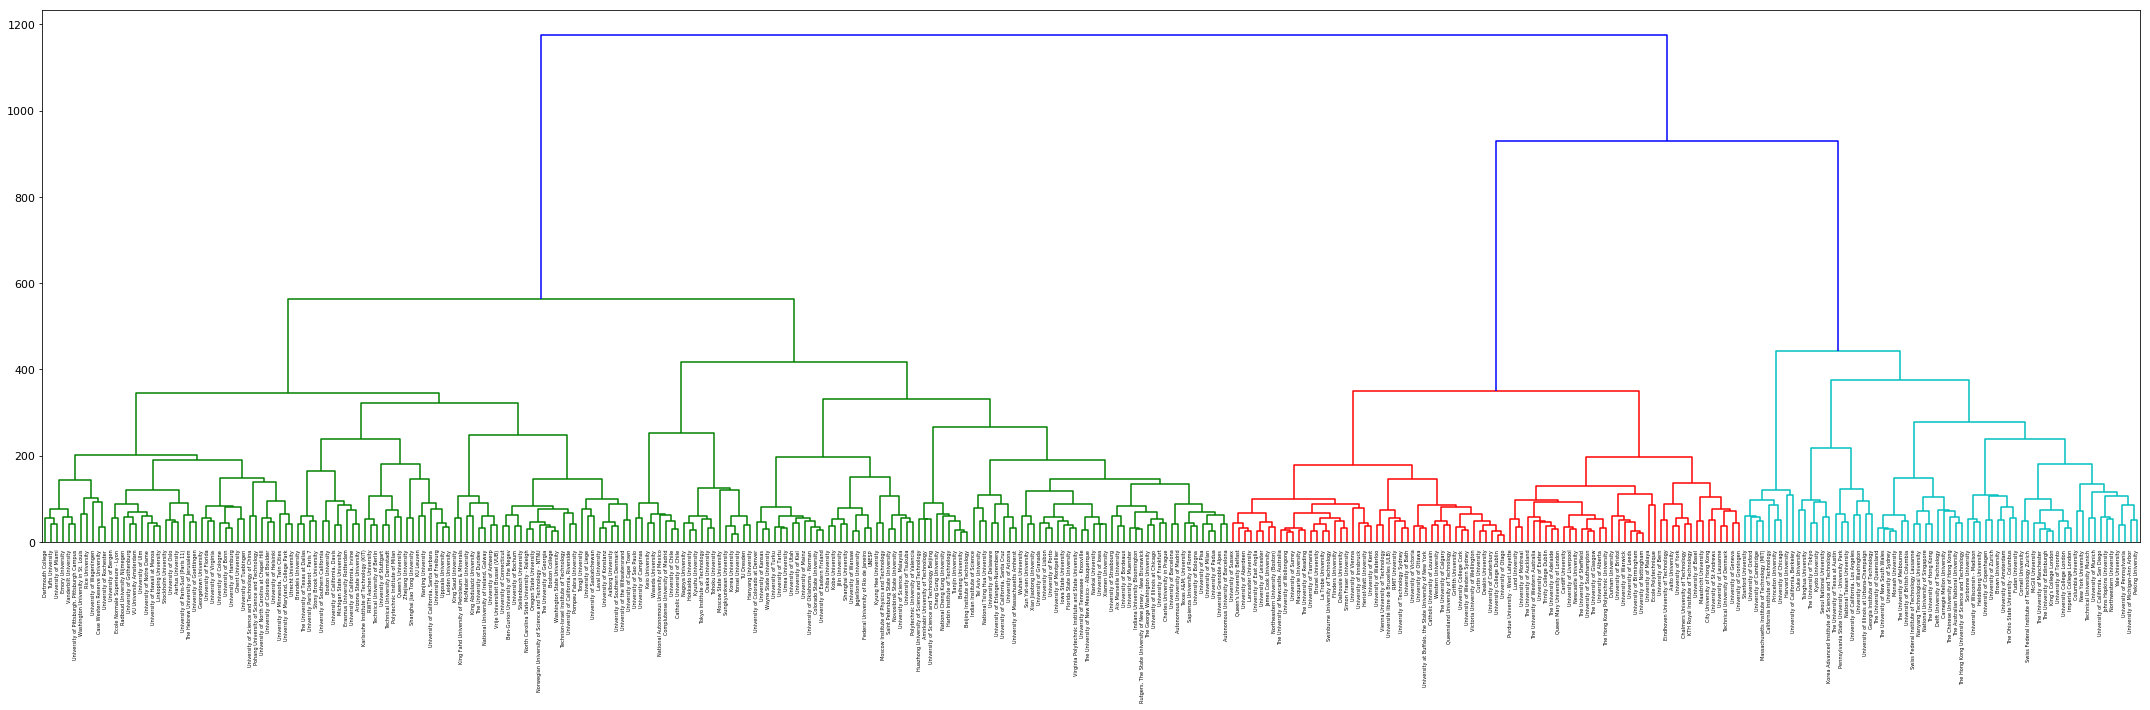

In [15]:
# Hierachical clustering
df_HCluster = df_data.copy()

linked = linkage(df_HCluster, 'ward')

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(30, 10))
dendrogram(
            linked,
            orientation='top',
            labels=df_HCluster.index.values,
            distance_sort='descending',
            show_leaf_counts=False
          )
plt.tight_layout()
# plt.savefig('test.png', dpi=1000)

cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model = cluster.fit(df_HCluster)
clust_labels = cluster.fit_predict(df_HCluster)
df_HCluster['HCluster'] = clust_labels

In [16]:
# Calculate PCA for visualisation purposes
df_pca = df_data.copy()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca.values)
df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.41209497 0.21580807]


### Plotly Settings

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

layout1 = go.Layout(
    hovermode= 'closest',
    title='K-Means Clustering + PCA',
    xaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    ),
    yaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    )
)

layout2 = go.Layout(
    hovermode= 'closest',
    title='Hierachical Clustering + PCA',
    xaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    ),
    yaxis=dict(
        showspikes=False,
        autorange=True,
        zeroline=False,
        ticks='',
    )
)

trace1 = go.Scatter(
    x = df_pca['pca-one'],
    y = df_pca['pca-two'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = df_kmeans['kmeans'],
        colorscale='Viridis'),
    text = df_pca.index.values,
)

trace2 = go.Scatter(
    x = df_pca['pca-one'],
    y = df_pca['pca-two'],
    mode = 'markers',
    marker = dict(
        size = 10,
        color = df_HCluster['HCluster'],
        colorscale='Viridis'),
    text = df_pca.index.values,
)

In [9]:
data1 = [trace1]
fig = go.Figure(data=data1, layout=layout1)
py.iplot(fig, filename='axes-booleans')

In [10]:
data2 = [trace2]
fig2 = go.Figure(data=data2, layout=layout2)
py.iplot(fig2, filename='axes-booleans2')